In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
from time import sleep

## Problem Understanding

The data provided comes from IBM which records transactions that contain a variable that indicates the transaction is considered an act of money laundering. The main objective in this case is to create a model that can predict whether money laundering will occur or not, which can be done using various models. Based on the data obtained, further cleaning and processing of the data is required before modeling, such as outlier cleaning, data balancing, and feature encoding so that the prediction results produced by the model are accurate. The EDA process is also carried out before feature encoding so that understanding of the data becomes deeper.

The common problems of fraud detection is the large amount of data that is in the majority class compared to the minority class. This results in models that can achieve very high accuracy despite not detecting any of the fraud it is supposed to detect. Several methods have been devised to create models that is more suitable for this type of imbalanced data such as over sampling and under sampling. In the modelling process, it is also crucial to not hyper focus on the accuracy of the model but instead also look at the other performance metrics such as recall and f1 score. Striking a balance between identifying potential fraud and avoiding false positives is crucial. Too many false positives can lead to inconvenience for legitimate users and erode trust in the system.

#### Loading a large amount of data is more efficient using the dask python library to segregate the data into several partitions

In [2]:
from dask import dataframe as dd
HI = dd.read_csv('HI-Large_Trans.csv', blocksize='50MB')
LI = dd.read_csv('LI-Large_Trans.csv',  blocksize='50MB')

In [3]:
df = dd.concat([HI, LI], axis = 0)

In [11]:
df.dtypes

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object

## Data Processing + EDA

#### Changing the Timestamp feature to date_time data type so it can be used for further analysis

In [4]:
df = df.map_partitions(lambda partition, col = "Timestamp": partition.assign(**{col: pd.to_datetime(partition[col])}), meta = {**{"Timestamp": 'datetime64[ns]'}, **df.dtypes[1:].to_dict()})

#### Checking for null values in the dataset

In [13]:
df.isna().sum().compute()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

#### Finding the all unique currencies in the dataset

In [65]:
df.groupby(["Payment Currency"])["Payment Currency"].count().compute()

Payment Currency
Australian Dollar     10600483
Bitcoin                7489817
Brazil Real            8452701
Canadian Dollar       11742551
Euro                  82712449
Mexican Peso           8805753
Ruble                 10072030
Rupee                 11074564
Saudi Riyal            6829211
Shekel                11494169
Swiss Franc           10304839
UK Pound              11095476
US Dollar            132538979
Yen                    9884688
Yuan                  22671076
Name: Payment Currency, dtype: int64

#### Converting all the currencies into a standardized one because of their extremely different exchange rates. The chosen standard currency is the US Dollar

In [5]:
# Exchange rates of all the Currencies into US dollars, using the average exchange rate of the currencies in 2022
#https://www.irs.gov/individuals/international-taxpayers/yearly-average-currency-exchange-rates

unique_currencies = ["US Dollar", "Euro", "UK Pound", "Bitcoin", "Yen", "Yuan", "Canadian Dollar", "Rupee", "Australian Dollar", "Ruble", "Shekel", "Brazil Real", "Mexican Peso", "Swiss Franc","Saudi Riyal"]
exchange_rates = [1, 0.951, 0.811, 2.32*10**(-5), 131.454, 6.730, 1.301, 78.598, 1.442, 69.896, 3.361, 5.165, 20.110, 0.955, 3.755 ]


def update_rows(partition):
    for i in range(len(unique_currencies)):
        mask = partition['Receiving Currency'] == unique_currencies[i]
        partition.loc[mask, 'Amount Received'] /= exchange_rates[i]
        mask = partition["Payment Currency"] == unique_currencies[i]
        partition.loc[mask, 'Amount Paid'] /= exchange_rates[i]
    return partition

df = df.map_partitions(update_rows,  meta = df)

df.head()
    

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-08-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022-08-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022-08-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022-08-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022-08-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


In [12]:

from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

#### Using a boxplot to see the distribution of the numerical features in the dataset (only the first 200 partitions)

100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


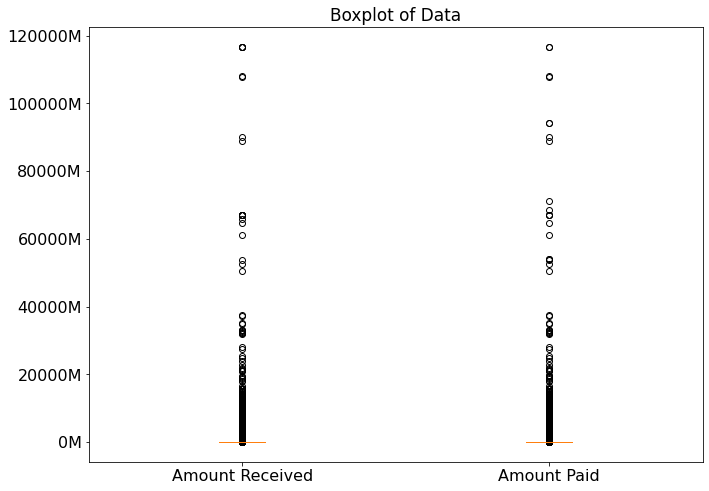

In [18]:
df_amount_received = np.empty((0, 2))

for i in tqdm(range(200)):
    df_temp = np.array(df.get_partition(i)[["Amount Received", "Amount Paid"]].compute())
    df_amount_received = np.vstack((df_amount_received, df_temp))

plt.figure(figsize=(11,8))
_= plt.boxplot(df_amount_received)
plt.title("Boxplot of Data", fontsize = 17)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

_= plt.xticks([1,2], ["Amount Received", "Amount Paid"], fontsize = 16)
_= plt.yticks(fontsize = 16)



#### The dataset contains alot of outliers, therefore we will use an outlier removal technique 

##### The technique we will usse is the MAD(Median Approximate Deviation) method because the MAD method works well with data with many extreme outliers because its uses the median of the data instead of the mean like many other methods

In [6]:
def filter_df(partition):
    Median = np.median(partition["Amount Received"])

    d = (partition["Amount Received"] - Median).abs()
    MAD = np.median(d)
    bound = MAD * 3
    

    Median2 = np.median(partition["Amount Paid"])

    s = (partition["Amount Paid"] - Median2).abs()
    MAD2 = np.median(s)
    bound2 = MAD2 * 3

    return  partition.loc[(d < bound) & (s < bound2)]

filtered_df_MAD = df.map_partitions(filter_df)


#### This is the resulting distribution of the data after outlier removal (only the first 200 partitions)

In [14]:
bins_count = 80

hist1 = np.zeros(bins_count)
hist2 = np.zeros(bins_count)
bins_setting = np.linspace(0, 80, bins_count + 1)


for i in tqdm(range(200)):
    df_temp = filtered_df_MAD.get_partition(i)[["Amount Received","Amount Paid"]].compute()
    new_counts, _ = np.histogram(df_temp["Amount Received"], bins = bins_setting)
    hist1 += new_counts
    new_counts, _ = np.histogram(df_temp["Amount Paid"], bins = bins_setting)
    hist2 += new_counts

100%|██████████| 200/200 [06:09<00:00,  1.85s/it]


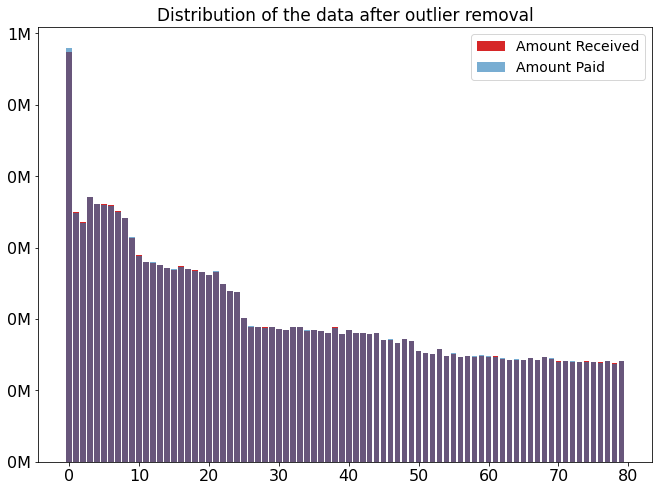

In [17]:
plt.figure(figsize=(11,8))
plt.title("Distribution of the data after outlier removal", fontsize = 17)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
_=plt.bar(bins_setting[:-1], hist1, label="Amount Received", color = "tab:red")
_=plt.bar(bins_setting[:-1], hist2, label="Amount Paid", color = "tab:blue", alpha= 0.6)

plt.legend(fontsize = 14)
plt.show()

#### The distribution of the data is skewed. We can use a log transformation to remove the skewness in the data

#### This data also still has outliers but instead of further decreasing the amount of data we can use log transformation which also decreases the number of outliers

#### Log transformation can help normalize the distribution of data. It makes the data more useful to techniques and models that assume normality.

In [7]:
def log_transform(partition):
    partition = partition.replace([np.inf, -np.inf], np.nan)
    partition.dropna()
    partition['Amount Received'] = np.log(partition['Amount Received'])
    partition['Amount Paid'] = np.log(partition['Amount Paid'])
    return partition

df_transformed = df.map_partitions(log_transform)


#### Histogram of the data after logarithmic transformation (only the first 200 partitions)

In [23]:
bins_count = 30

hist3 = np.zeros(bins_count)
hist4 = np.zeros(bins_count)
bins_setting = np.linspace(0, 26, bins_count + 1)


for i in tqdm(range(200)):
    df_temp = df_transformed.get_partition(i)[["Amount Received","Amount Paid"]].compute()
    new_counts, _ = np.histogram(df_temp["Amount Received"], bins = bins_setting)
    hist3 += new_counts
    new_counts, _ = np.histogram(df_temp["Amount Paid"], bins = bins_setting)
    hist4 += new_counts

100%|██████████| 200/200 [09:30<00:00,  2.85s/it]


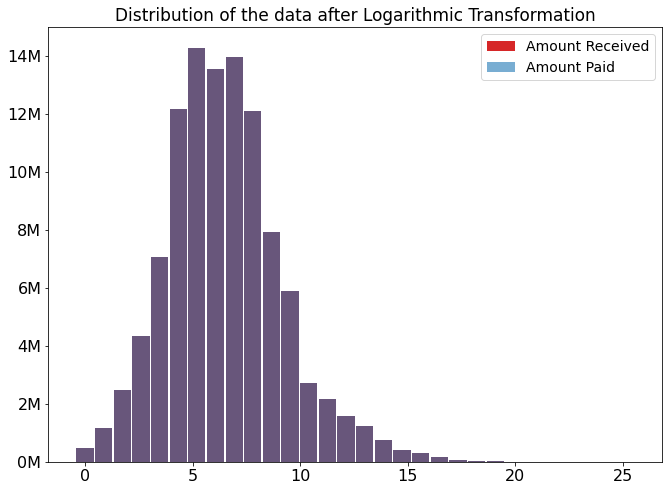

In [27]:
plt.figure(figsize=(11,8))
plt.title("Distribution of the data after Logarithmic Transformation", fontsize = 17)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
_=plt.bar(bins_setting[:-1], hist3, label="Amount Received", color = "tab:red")
_=plt.bar(bins_setting[:-1], hist4, label="Amount Paid", color = "tab:blue", alpha= 0.6)

plt.legend(fontsize = 14)
plt.show()


#### Of all the laundering cases which method is the most frequent (only first 200 partitions)

Processing: 100%|██████████| 200/200 [06:00<00:00,  1.80s/it]


Text(0.5, 0, 'Payment Format')

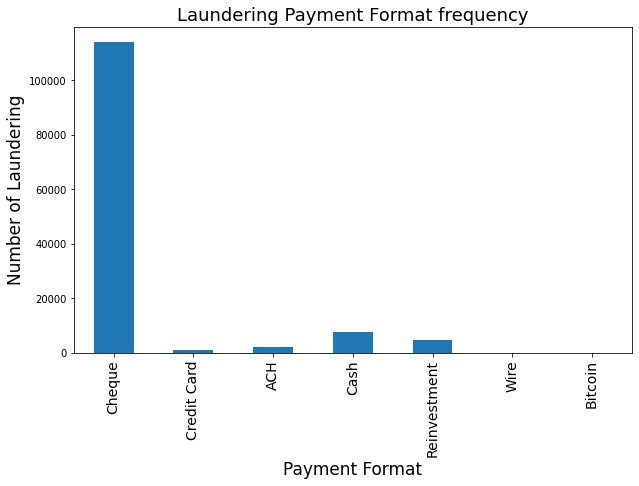

In [34]:
payment_format_count = pd.Series(data = [0,0,0,0,0,0,0], index = ["Cheque", "Credit Card", "ACH", "Cash", "Reinvestment", "Wire", "Bitcoin"])


for i in tqdm(range(200), desc='Processing'):
    df_temp = df.get_partition(i).compute()
    payment_format_temp = df_temp[df_temp["Is Laundering"] == 1]["Payment Format"].value_counts()
    payment_format_count =  payment_format_count.add(payment_format_temp, fill_value=0)
    
plt.figure(figsize=(10,6))
payment_format_count.plot.bar()
plt.title("Laundering Payment Format frequency", fontsize = 18)
plt.xticks([0,1,2,3,4,5,6],["Cheque", "Credit Card", "ACH", "Cash", "Reinvestment", "Wire", "Bitcoin"], fontsize = 14)
plt.ylabel("Number of Laundering", fontsize = 17)
plt.xlabel("Payment Format", fontsize = 17)

#### A comparison of the number of laundering cases and legal cases

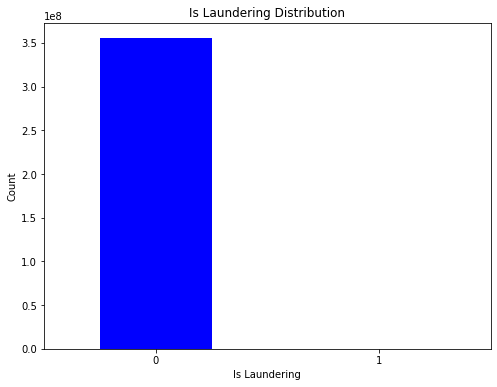

In [36]:
count_laundering = df_transformed['Is Laundering'].value_counts().compute()

plt.figure(figsize=(8, 6))
count_laundering.plot(kind='bar', color=['blue', 'red'])
plt.title('Is Laundering Distribution')
plt.xlabel('Is Laundering')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### The data is very imbalanced

##### To deal with the data imbalance problem we decided to use undersampling. This method is often not viable because of the loss of potential training data but in this case since the data is so large we are still able to use a large train and test sized data even after undersampling

In [8]:
#balancing dataset

def balancer(partition):
    not_frauds = partition[partition["Is Laundering"] == 0]
    frauds = partition[partition["Is Laundering"] == 1]

    return pd.concat([frauds, not_frauds.sample(len(frauds))])

balanced_df = df_transformed.map_partitions(balancer, meta = df_transformed)

balanced_df = balanced_df.repartition(npartitions=300)

In [18]:
balanced_df_computed = [balanced_df.get_partition(partition_index) for partition_index in range(300)]
balanced_df_computed = dd.concat(balanced_df_computed, interleave_partitions=True)

balanced_df_computed = balanced_df_computed.compute()

#### After Undersampling the data the number of laundering cases and legal cases are the same

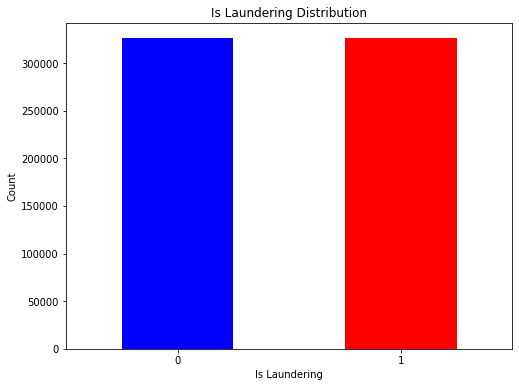

In [9]:
count_laundering_balanced = balanced_df['Is Laundering'].value_counts().compute()

plt.figure(figsize=(8, 6))
count_laundering_balanced.plot(kind='bar', color=['blue', 'red'])
plt.title('Is Laundering Distribution')
plt.xlabel('Is Laundering')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## FEATURE ENGINEERING

In [40]:
copy_featurengineering = balanced_df_computed.copy()

copy_featurengineering.columns = copy_featurengineering.columns.str.replace(' ', '_')

#### Create new features to be used as input data to capture relevant information in data

In [41]:
copy_featurengineering.head()

,Timestamp,From_Bank,Account,To_Bank,Account.1,Amount_Received,Receiving_Currency,Amount_Paid,Payment_Currency,Payment_Format,Is_Laundering
27581,2022-08-01 00:19:00,70,100428660,8381,8035B3E00,10.233336,US Dollar,10.233336,US Dollar,Cheque,1
133037,2022-08-01 00:28:00,70,100428660,29630,814B11040,11.368276,US Dollar,11.368276,US Dollar,Cheque,1
141113,2022-08-01 00:06:00,215275,816439360,235985,816439870,8.334183,US Dollar,8.334183,US Dollar,ACH,1
154375,2022-08-01 00:05:00,70,100428660,220255,818305750,9.221382,US Dollar,9.221382,US Dollar,Cheque,1
161098,2022-08-01 00:16:00,70,100428660,1922,8192DF510,5.088584,US Dollar,5.088584,US Dollar,Cash,1


#### Same Account (binary category of if the start transaction acccount is the same with the end receiving account)

#### Same Bank (binary category of if the start bank is the same with the end bank)

#### Same Amount (binary category of if the start transaction amount is the same with the end transaction amount )

In [42]:
copy_featurengineering['Same Account'] = (copy_featurengineering['Account'] == copy_featurengineering['Account.1']).astype(int)
copy_featurengineering['Same Bank'] = (copy_featurengineering['To_Bank'] == copy_featurengineering['From_Bank']).astype(int)
copy_featurengineering['Same Amount'] = (copy_featurengineering['Amount_Received'] == copy_featurengineering['Amount_Paid']).astype(int)

copy_featurengineering.head()

,Timestamp,From_Bank,Account,To_Bank,Account.1,Amount_Received,Receiving_Currency,Amount_Paid,Payment_Currency,Payment_Format,Is_Laundering,Same Account,Same Bank,Same Amount
27581,2022-08-01 00:19:00,70,100428660,8381,8035B3E00,10.233336,US Dollar,10.233336,US Dollar,Cheque,1,0,0,1
133037,2022-08-01 00:28:00,70,100428660,29630,814B11040,11.368276,US Dollar,11.368276,US Dollar,Cheque,1,0,0,1
141113,2022-08-01 00:06:00,215275,816439360,235985,816439870,8.334183,US Dollar,8.334183,US Dollar,ACH,1,0,0,1
154375,2022-08-01 00:05:00,70,100428660,220255,818305750,9.221382,US Dollar,9.221382,US Dollar,Cheque,1,0,0,1
161098,2022-08-01 00:16:00,70,100428660,1922,8192DF510,5.088584,US Dollar,5.088584,US Dollar,Cash,1,0,0,1


##### Creating seasonality features

Month (month of transaction) (Removed from modelling because of low significance)

Quarter (quarter of transaction) (Removed from modelling because of low significance)

Dayofyear (day of year of transaction) (Removed from modelling because of low significance)

In [43]:
# copy_featurengineering = copy_featurengineering.assign(Month= lambda partition:  partition["Timestamp"].dt.month)
# copy_featurengineering = copy_featurengineering.assign(Quarter= lambda partition:  partition["Timestamp"].dt.quarter)
# copy_featurengineering = copy_featurengineering.assign(Dayofyear= lambda partition:  partition["Timestamp"].dt.dayofyear)

# copy_featurengineering.head()

##### Deleted some features which aren't suitable for model creation
a. Account

b. Account.1

c. Timestamp

d. From Bank

e. To Bank

In [44]:
copy_featurengineering = copy_featurengineering.drop(columns = "Account")
copy_featurengineering = copy_featurengineering.drop(columns = "Account.1")
copy_featurengineering = copy_featurengineering.drop(columns = "Timestamp")
copy_featurengineering = copy_featurengineering.drop(columns = "From_Bank")
copy_featurengineering = copy_featurengineering.drop(columns = "To_Bank")

##### Transformed the categorical features using one hot encoding, the features that we transformed are:

a. Receiving Currency

b. Payment Format

c. Same Account

d. Same Bank

e. Same Amount

In [45]:
copy_featurengineering = pd.get_dummies(copy_featurengineering, columns=["Receiving_Currency", "Payment_Format", "Payment_Currency", 'Same Account', 'Same Bank', 'Same Amount'], drop_first=True)
copy_featurengineering.head()

,Amount_Received,Amount_Paid,Is_Laundering,Receiving_Currency_Bitcoin,Receiving_Currency_Brazil Real,Receiving_Currency_Canadian Dollar,Receiving_Currency_Euro,Receiving_Currency_Mexican Peso,Receiving_Currency_Ruble,Receiving_Currency_Rupee,...,Payment_Currency_Saudi Riyal,Payment_Currency_Shekel,Payment_Currency_Swiss Franc,Payment_Currency_UK Pound,Payment_Currency_US Dollar,Payment_Currency_Yen,Payment_Currency_Yuan,Same Account_1,Same Bank_1,Same Amount_1
27581,10.233336,10.233336,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
133037,11.368276,11.368276,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
141113,8.334183,8.334183,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
154375,9.221382,9.221382,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
161098,5.088584,5.088584,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


##### Used Standard Scaler to normalize the numerical features in the data (Amount Received and Amount Paid)

In [46]:
from sklearn.preprocessing import StandardScaler
SC = StandardScaler()

copy_featurengineering["Amount_Received"] = SC.fit_transform(np.array(copy_featurengineering["Amount_Received"]).reshape(-1,1))
copy_featurengineering["Amount_Paid"] = SC.fit_transform(np.array(copy_featurengineering["Amount_Paid"]).reshape(-1,1))


copy_featurengineering.head()

,Amount_Received,Amount_Paid,Is_Laundering,Receiving_Currency_Bitcoin,Receiving_Currency_Brazil Real,Receiving_Currency_Canadian Dollar,Receiving_Currency_Euro,Receiving_Currency_Mexican Peso,Receiving_Currency_Ruble,Receiving_Currency_Rupee,...,Payment_Currency_Saudi Riyal,Payment_Currency_Shekel,Payment_Currency_Swiss Franc,Payment_Currency_UK Pound,Payment_Currency_US Dollar,Payment_Currency_Yen,Payment_Currency_Yuan,Same Account_1,Same Bank_1,Same Amount_1
27581,1.080451,1.080186,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
133037,1.541315,1.540908,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
141113,0.309265,0.309237,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
154375,0.669529,0.669390,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
161098,-1.008672,-1.008294,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


## MODELING + Performance Metrics


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### Creating an X and Y df, separating the independent and dependent variables

In [49]:
DF_X_b = copy_featurengineering.drop(columns = "Is_Laundering")
DF_Y_b = copy_featurengineering[["Is_Laundering"]]


#### Split the data ( 70 : 30 )

In [50]:
Xtrain_temp, Xtest_temp, Ytrain_temp, Ytest_temp = train_test_split(DF_X_b, DF_Y_b, test_size= 0.3)

#### Random Forest Classifer

In [53]:
from sklearn.ensemble import RandomForestClassifier
rd = RandomForestClassifier(n_estimators=200, criterion="gini")
rd.fit(Xtrain_temp, Ytrain_temp)

prediction = rd.predict(Xtest_temp)

print("Random Forest Classification\n")
print(classification_report(Ytest_temp, prediction), "\n\n")
print("Confusion Matrix\n")
print(confusion_matrix(Ytest_temp, prediction))

C:\Users\Andy\AppData\Local\Temp\ipykernel_11420\1185741660.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rd.fit(Xtrain_temp, Ytrain_temp)


Random Forest Classification

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     97849
           1       0.81      0.81      0.81     97841

    accuracy                           0.81    195690
   macro avg       0.81      0.81      0.81    195690
weighted avg       0.81      0.81      0.81    195690
 


Confusion Matrix

[[79344 18505]
 [18595 79246]]


#### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter=500, solver= 'liblinear')
lg.fit(Xtrain_temp, Ytrain_temp)


prediction = lg.predict(Xtest_temp)

print("Logistic Regression Classification\n")
print(classification_report(Ytest_temp, prediction), "\n\n")
print("Confusion Matrix\n")
print(confusion_matrix(Ytest_temp, prediction))


c:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Classification

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     97849
           1       0.88      0.84      0.86     97841

    accuracy                           0.86    195690
   macro avg       0.86      0.86      0.86    195690
weighted avg       0.86      0.86      0.86    195690
 


Confusion Matrix

[[86694 11155]
 [15545 82296]]


#### KNN Classifier

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(Xtrain_temp, Ytrain_temp)


prediction = knn.predict(Xtest_temp)

print("KNN Classification\n")
print(classification_report(Ytest_temp, prediction), "\n\n")
print("Confusion Matrix\n")
print(confusion_matrix(Ytest_temp, prediction))

c:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Classification

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     97849
           1       0.91      0.83      0.87     97841

    accuracy                           0.88    195690
   macro avg       0.88      0.88      0.88    195690
weighted avg       0.88      0.88      0.88    195690
 


Confusion Matrix

[[90131  7718]
 [16562 81279]]


#### MLP Classifier

In [54]:
from sklearn.neural_network import MLPClassifier
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100,50), 
    max_iter=1000,               
)

mlp_classifier.fit(Xtrain_temp, Ytrain_temp)


prediction = mlp_classifier.predict(Xtest_temp)

print("Multi-layer Perceptron Classifier\n")
print(classification_report(Ytest_temp, prediction), "\n\n")
print("Confusion Matrix\n")
print(confusion_matrix(Ytest_temp, prediction))

c:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1096: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multi-layer Perceptron Classifier

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     97849
           1       0.91      0.83      0.87     97841

    accuracy                           0.88    195690
   macro avg       0.88      0.88      0.88    195690
weighted avg       0.88      0.88      0.88    195690
 


Confusion Matrix

[[90114  7735]
 [16428 81413]]


## The model with the highest recall for laundering cases is the logistic regression which 0.84

## The model with the highest combined F1_score from both classes are KNN classification and MLP Classifier

### More often a higher recall of fraud classification is more desirable to ensure that loses to banks are minimized. So the logistic regression model is the good choice for thie problem. But we should also consider that the precision and Not Fraud recall from the KNN and MLP classifier models are higher with the Fraud recall being only slightly less accurate than the logistic regression model